## BART Comparative Station Analysis

In [681]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
if not os.path.exists("images"): 
    os.mkdir("images")

In [682]:
#Import 2019 Preprocessing Destination Data. 

df = pd.read_csv('date-hour-soo-dest-2019.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['Month'] = df['Date'].dt.month
df['Month Name'] = df['Date'].dt.month_name()
destination2019 = df.groupby(['Month Name','Month','Destination Station'])['Trip Count'].sum(
).reset_index().sort_values(by=['Month']).reset_index().drop(columns = ['index']).rename(columns = {'Destination Station':'Station',
                                                                                                          'Trip Count':'2019'})
destination2019.head(2)

,Month Name,Month,Station,2019
0,January,1,CONC,131512
1,January,1,LAFY,83214


In [657]:
#Import 2019 Preprocessing Origin Data. 
df = pd.read_csv('date-hour-soo-dest-2019.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['Month'] = df['Date'].dt.month
df['Month Name'] = df['Date'].dt.month_name()
# df['Year'] = df['Date'].dt.year
origin2019 = df.groupby(['Month Name','Month','Origin Station'])['Trip Count'].sum(
).reset_index().sort_values(by=['Month']).reset_index().drop(columns = ['index']).rename(columns = 
                                                                                         {'Origin Station':'Station','Trip Count':'2019'})
origin2019.head(2)

,Month Name,Month,Station,2019
0,January,1,CONC,131502
1,January,1,LAFY,81229


In [658]:
#2019 concatenation and output
station_19 = pd.concat([destination2019,origin2019])
station_19 = station_19.groupby(['Month Name','Month','Station'])[['2019']].sum().reset_index()
station_19.head(2)

,Month Name,Month,Station,2019
0,April,4,12TH,666117
1,April,4,16TH,665159


In [659]:
#2023 Import
station_23_stitch = []
for k,v in {'May':'202305','June':'202306','July':'202307','August':'202308','September':'202309','October':'202310','November':'202311','December':'202312'}.items():
    tdf = pd.pandas.read_excel('ridership_2023/Ridership_' + v + '.xlsx', header = 1, index_col=0, sheet_name = 'Total Trips OD')
    tdf = pd.concat([tdf.T[['Entries']].reset_index().drop([tdf.T[['Entries']].shape[0]-1]),
           tdf[['Exits']].reset_index().drop([tdf[['Exits']].shape[0]-1]).rename(columns = {'Exits':'Entries'})]
         ).groupby('index').sum().reset_index().rename(columns = {'index':'Station','Entries':'Trip Count'})
    tdf['Month Name'] = k
    tdf['Month'] = dt.datetime.strptime(v, "%Y%m").month
    tdf['Station'] = tdf['Station'].astype(str)
    tdf = tdf.merge(station_abr_merge, how = 'left', left_on = 'Station',right_on = 'Two-Letter Station Code')
    tdf = tdf[['Month Name','Month','Abbr','Trip Count']].rename(columns = {'Abbr': 'Station','Trip Count':'2023'})
    station_23_stitch.append(tdf)

In [660]:
#2024 Import
for k,v in {'January':'202401','February':'202402','March':'202403','April':'202404'}.items():
    ddf = pd.pandas.read_excel('ridership_2023/Ridership_' + v + '.xlsx', header = 1, index_col=0, sheet_name = 'Total Trips',skiprows=3)
    GT = ddf.T[['Grand Total']].drop(['Unnamed: 51'])
    Un51 = ddf[['Unnamed: 51']].drop(['Grand Total']).rename(columns = {'Unnamed: 51':'Grand Total'})
    tdf = pd.concat([GT,Un51]).reset_index().groupby('index')[['Grand Total']].sum().reset_index().rename(columns= {'index':'Station','Grand Total':'Trip Count'})
    tdf['Month Name'] = k
    tdf['Month'] = dt.datetime.strptime(v, "%Y%m").month
    tdf['Station'] = tdf['Station'].astype(str)
    tdf = tdf.merge(station_abr_merge, how = 'left', left_on = 'Station',right_on = 'Two-Letter Station Code')
    tdf = tdf[['Month Name','Month','Abbr','Trip Count']].rename(columns = {'Abbr': 'Station','Trip Count':'2023'})
    tdf[['2023']].convert_dtypes()
    station_23_stitch.append(tdf)

In [661]:
#2023 + 2024
station_stitch = pd.concat(station_23_stitch)
station_stitch.head(2)

,Month Name,Month,Station,2023
0,May,5,12TH,234249.0
1,May,5,16TH,301411.0


In [663]:
#2019 + 2023 + 2024
final_st_merge = station_19.merge(station_stitch, how = 'left', 
                                  left_on = ['Month Name','Month','Station'], 
                                  right_on=['Month Name','Month','Station'])
station_19v23 = final_st_merge.groupby('Station')[['2019','2023']].sum().reset_index()
station_19v23['Type'] = 'Other Stations'
station_19v23.loc[station_19v23['Station'].isin(['SFIA','OAKL']),'Type'] = 'Airport'
station_19v23.loc[station_19v23['Station'].isin(['EMBR','POWL','CIVC','MONT']),'Type'] = 'SF Downtown' 
station_19v23.head(2)

,Station,2019,2023,Type
0,12TH,7759318,2839602.0,Other Stations
1,16TH,7739460,3501328.0,Other Stations


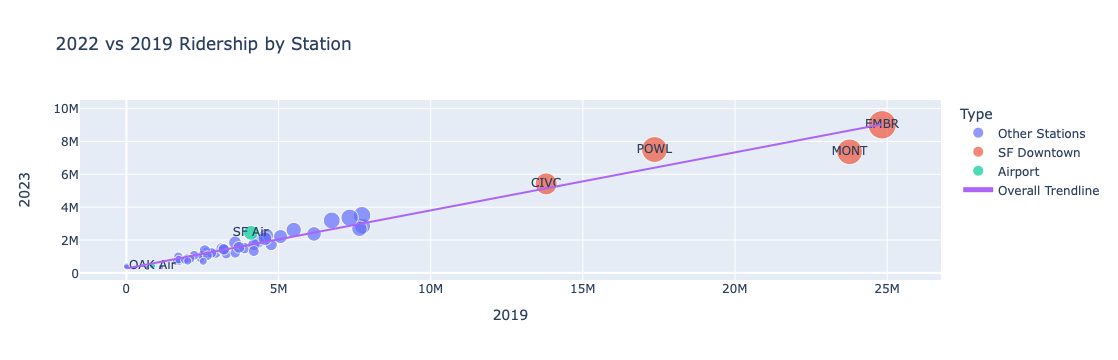

In [684]:
# Bounceback Analysis
texts = [''] * 50
texts[18] = 'EMBR'
texts[28] = 'MONT'
texts[37] = 'POWL'
texts[10] = 'CIVC'
texts[42] = 'SF Air'
texts[31] = 'OAK Air'

ratio_scat = px.scatter(station_19v23,
                         x="2019", 
                         y="2023",
                         labels={"Trip Count_2019":"2019","Trip Count_2022":"2022"},
                        color = "Type",
                         trendline="ols", trendline_scope="overall",
                        text = texts,
                        hover_data=["Station"],
                        size="2023", size_max=20,
                         title = "2022 vs 2019 Ridership by Station")
# ratio_scat.add_trace(
#     go.Scatter(x=station_19v23['2019'], y=station_19v23['2019'], name="100% Bounceback", line_shape='linear')
# )
ratio_scat.update_layout(hovermode="x")
# ratio_scat.update_yaxes(range = [0,40000000])
ratio_scat.write_image("images/ratio_scat.png")
ratio_scat.write_image("images/ratio_scat.svg")
ratio_scat.show()

Station Performance:
- SF Downtown are the busiest stations. 
- POWL is the hub of shopping and retail.
- MONT underperforms. MONT is the hub of corporate offices / Financial District.
- EMBR and CIVC are on the trendline. EMBR is a mix of offices and tourism which CIVC is all SF City Jobs and City Hall. 

Regression line is .35 --> bounceback is 35%

Other Data points of note: SF Airport


In [708]:
#Downtown Bounceback stats and calculations

station_19v23['Bounceback'] = station_19v23['2023']/station_19v23['2019']
# station_19v23 = station_19v23.sort_values(by = 'Bounceback',ascending = False).drop([8,27])
station_19v23['2019 Rank'] = station_19v23['2019'].rank(ascending = False)
station_19v23['2023 Rank'] = station_19v23['2023'].rank(ascending = False)
station_19v23[station_19v23['Station'].isin(['MONT','EMBR','CIVC','POWL'])]

,Station,2019,2023,Type,Bounceback,2019 Rank,2023 Rank
10,CIVC,13792756,5417672.0,SF Downtown,0.392791,4.0,4.0
18,EMBR,24836028,9012387.0,SF Downtown,0.362876,1.0,1.0
28,MONT,23767969,7371293.0,SF Downtown,0.310136,2.0,3.0
37,POWL,17355760,7507818.0,SF Downtown,0.432584,3.0,2.0


In [685]:
# Share of total volume for Airport, SF Downtown and Other Stations
dt_volume = station_19v23.groupby('Type')[['2019','2023']].agg('sum')
dt_volume['2019_Vol'] = dt_volume['2019']/dt_volume['2019'].sum()
dt_volume['2023_Vol'] = dt_volume['2023']/dt_volume['2023'].sum()
dt_volume

,2019,2023,2019_Vol,2023_Vol
Type,,,,
Airport,4937473,2860337.0,0.020814,0.029367
Other Stations,152529224,65229870.0,0.642988,0.669715
SF Downtown,79752513,29309170.0,0.336198,0.300917


## Station Route Heat Map

In [722]:
#Import 2023
df202312 = pd.read_excel('ridership_2023/Ridership_202312.xlsx', header = 1,index_col=0,sheet_name = 'Total Trips OD')
df202312 = df202312.drop('Entries').drop(columns = 'Exits')
df202312.columns = pd.DataFrame(df202312.columns.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
df202312.index = pd.DataFrame(df202312.index.astype(str)).merge(
    station_abr_merge, how ='left', left_on = 0, right_on='Two-Letter Station Code')['Abbr'].to_list()
df202312.head(2)

,RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,LAKE,...,SBRN,SFIA,MLBR,WDUB,OAKL,WARM,MLPT,BERY,PCTR,ANTC
RICH,482,1690,1540,847,5216,1237,1891,1394,1642,484,...,302,1090,315,57,203,256,206,212,103,239
DELN,1758,523,1465,1100,7445,1400,2554,3062,3994,843,...,403,1775,612,161,582,460,375,510,64,229


In [716]:
#Import 2019
df2019 = pd.read_csv('date-hour-soo-dest-2019.csv', header = 0)
df2019 = df2019.groupby(['Date','Origin Station','Destination Station'])['Trip Count'].sum().reset_index()
df2019['Date'] = pd.to_datetime(df2019['Date'], format = '%Y-%m-%d')
df2019['Month'] = df2019['Date'].dt.month
to_pivot = df2019.groupby(['Month','Origin Station','Destination Station'])['Trip Count'].sum().reset_index().groupby(
    ['Origin Station','Destination Station'])['Trip Count'].mean().reset_index()
to_pivot = to_pivot.pivot(index='Destination Station', columns='Origin Station', values='Trip Count')
to_pivot = to_pivot[df202312.columns.to_list()]
to_pivot = to_pivot.reindex(df202312.index.to_list())
to_pivot.head(2)

Origin Station,RICH,DELN,PLZA,NBRK,DBRK,ASHB,MCAR,19TH,12TH,LAKE,...,SBRN,SFIA,MLBR,WDUB,OAKL,WARM,MLPT,BERY,PCTR,ANTC
Destination Station,,,,,,,,,,,,,,,,,,,,,
RICH,788.250000,2785.916667,2337.083333,1710.25,10177.250000,2361.166667,3334.250000,3816.416667,4113.75,1190.500000,...,537.916667,1611.583333,644.166667,151.750000,366.916667,460.000000,NaN,NaN,249.416667,288.333333
DELN,2939.333333,776.250000,2115.916667,2084.00,18625.583333,3251.500000,5825.916667,10407.250000,12399.50,2489.916667,...,928.000000,3587.666667,1547.500000,289.416667,1033.333333,1145.833333,NaN,NaN,210.916667,274.500000


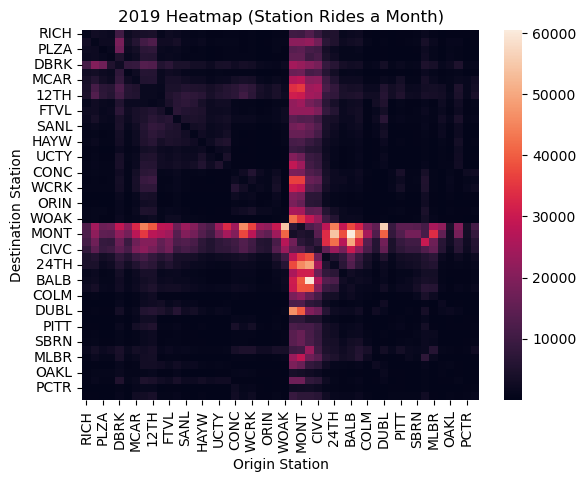

In [717]:
#2019 Heatmap

heatmap_2019 = sns.heatmap(to_pivot.drop(['MLPT','BERY']).drop(columns = ['MLPT','BERY'],))
plt.title("2019 Heatmap (Station Rides a Month)")
plt.xlabel("Origin Station")
plt.ylabel("Destination Station")
plt.savefig("images/2019_heatmap.svg")
plt.savefig("images/2019_heatmap.png")

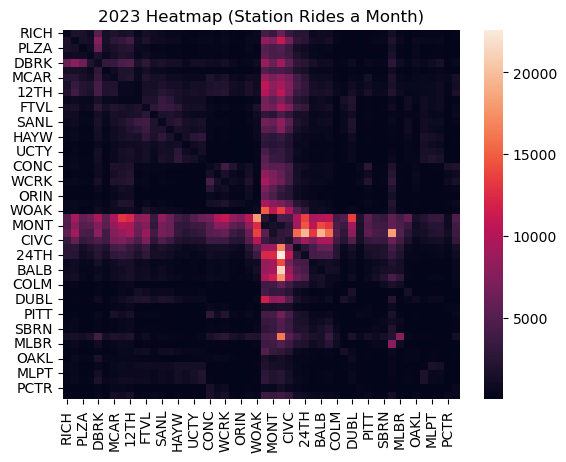

In [723]:
#2023 Route Map
sns.heatmap(df202312)
plt.title("2023 Heatmap (Station Rides a Month)")
plt.savefig("images/2023_heatmap.svg")
plt.savefig("images/2023_heatmap.png")

Heatmaps are pretty identical in 2019 v 2023, which different scales. 

MCAR / 12th (DT Oakland) and DT SF commute patterns are lesser. Cropping of MLBR to SF Downtown.

#### Background Data Station Matching

In [680]:
station_abr_merge = pd.pandas.read_csv('station_abr_merge_final.csv', header = 0, index_col=0)
station_abr_merge['Abbr'] = station_abr_merge['Abbr'].str.upper()
station_abr_merge

,Station Name,Two-Letter Station Code,Abbr
0,Richmond,RM,RICH
1,El Cerrito Del Norte,EN,DELN
2,El Cerrito Plaza,EP,PLZA
3,North Berkeley,NB,NBRK
4,Berkeley,BK,DBRK
5,Ashby,AS,ASHB
6,MacArthur,MA,MCAR
7,19th Street Oakland,19,19TH
8,12th Street / Oakland City Center,12,12TH
9,Lake Merritt,LM,LAKE
